# Mask Detection

## Dependencies

In [1]:
%config IPCompleter.greedy=True
%matplotlib inline

# Import the dependencies.
# OpenCV
import cv2

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow.keras import utils
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import (
    Dense,
    Activation,
    Flatten,
    Dropout,
    Conv2D,
    MaxPooling2D,
)
from tensorflow.keras.callbacks import ModelCheckpoint

# Helper libraries
import os
import numpy as np
import matplotlib.pyplot as plt

# Tensorflow Libraries Matter for Speed!!!
print(tf.__version__)

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

1.14.0


C:\ProgramData\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.

# Data Loading

In [2]:
# All this could be coverted to the pathlib module
# 

# Processed folder houses the already seperated image files
data_path = "../data/processed"
categories = os.listdir(data_path)
labels = [i for i in range(len(categories))]

# Initialize an empty dictionary for labels
label_dict = dict(zip(categories, labels))

print(label_dict)
print(categories)
print(labels)

{'without_mask': 0, 'with_mask': 1}
['without_mask', 'with_mask']
[0, 1]


# Data Preprocessing

In [3]:
img_size = 100
data = []
target = []


for category in categories:
    folder_path = os.path.join(data_path, category)
    img_names = os.listdir(folder_path)

    for img_name in img_names:
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path)

        try:
            # Coverting the image into gray scale
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            # Resizing the gray scale into 50x50, since we need a fixed common size for all the images in the dataset
            resized = cv2.resize(gray, (img_size, img_size))
            # Appending the image and the label(categorized) into the list (dataset)
            data.append(resized)
            target.append(label_dict[category])

        except Exception as e:
            # If any exception rasied, the exception will be printed here. And pass to the next image
            print("Exception:", e)

In [4]:
# Create a numpy array to store data and target
# Normalize data
data = np.array(data) / 255.0
data = np.reshape(data, (data.shape[0], img_size, img_size, 1))
target = np.array(target)

# Use the keras utils tool to create catagorical target
new_target = utils.to_categorical(target)

In [5]:
# https://numpy.org/doc/stable/reference/generated/numpy.save.html
np.save("numpy/data", data)
np.save("numpy/target", new_target)

# Training the Convolutional Neural Network

In [6]:
# Loading in the saved numpy arrays in the previous code
data = np.load("numpy/data.npy")
target = np.load("numpy/target.npy")

In [7]:
# Create the model
model = Sequential()

# The first CNN layer followed by Relu and MaxPooling layers
model.add(Conv2D(200, (3, 3), input_shape=data.shape[1:]))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

# The second convolution layer followed by Relu and MaxPooling layers
model.add(Conv2D(100, (3, 3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten layer to stack the output convolutions from second convolution layer
model.add(Flatten())
model.add(Dropout(0.5))

# Dense layer of 64 neurons
model.add(Dense(50, activation="relu"))
# The Final layer with two outputs for two categories
model.add(Dense(2, activation="softmax"))

# Compile the model
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [8]:
from sklearn.model_selection import train_test_split

# Use the train_test_split to split the data into training and testing set.
# The data set isnt very large so only using 10% to test.
train_data, test_data, train_target, test_target = train_test_split(
    data, target, test_size=0.1
)

In [9]:
checkpoint = ModelCheckpoint(
    "model_checkpoints/model-{epoch:03d}.model",
    monitor="val_loss",
    verbose=0,
    save_best_only=True,
    mode="auto",
)
history = model.fit(
    train_data, train_target, epochs=20, callbacks=[checkpoint], validation_split=0.2
)

Train on 2782 samples, validate on 696 samples
Epoch 1/20
2782/2782 [==============================] - 65s 23ms/sample - loss: 0.6265 - acc: 0.6528 - val_loss: 0.5220 - val_acc: 0.7658
Epoch 2/20
2782/2782 [==============================] - 60s 21ms/sample - loss: 0.4521 - acc: 0.7930 - val_loss: 0.3706 - val_acc: 0.8391
Epoch 3/20
2782/2782 [==============================] - 67s 24ms/sample - loss: 0.3729 - acc: 0.8418 - val_loss: 0.3220 - val_acc: 0.8520
Epoch 4/20
2782/2782 [==============================] - 64s 23ms/sample - loss: 0.3245 - acc: 0.8541 - val_loss: 0.3102 - val_acc: 0.8678
Epoch 5/20
2782/2782 [==============================] - 63s 23ms/sample - loss: 0.2646 - acc: 0.8907 - val_loss: 0.2727 - val_acc: 0.8807
Epoch 6/20
2782/2782 [==============================] - 63s 23ms/sample - loss: 0.2318 - acc: 0.9065 - val_loss: 0.2471 - val_acc: 0.8851
Epoch 7/20
2782/2782 [==============================] - 64s 23ms/sample - loss: 0.2027 - acc: 0.9184 - val_loss: 0.2484 - val

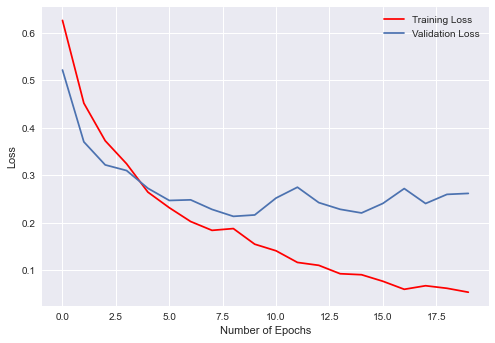

In [10]:
# Chart of What?
# Defined style for plot
plt.style.use('seaborn')
plt.plot(history.history["loss"], "r", label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig("../resources/loss.png")
plt.show()

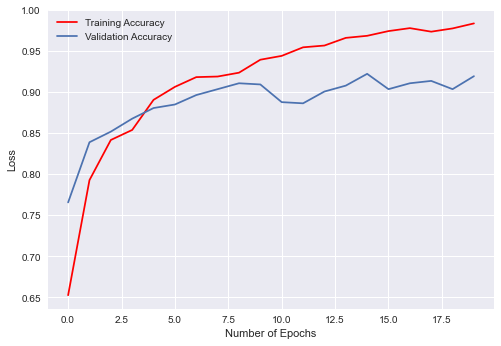

In [15]:
# Another Chart of what
# Defined style for plot
plt.style.use('seaborn')
plt.plot(history.history["acc"], "r", label="Training Accuracy")
plt.plot(history.history["val_acc"], label="Validation Accuracy")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig("../resources/accuracy.png")
plt.show()

In [12]:
print(model.evaluate(test_data, test_target))

387/387 [==============================] - 2s 5ms/sample - loss: 0.2106 - acc: 0.9302
[0.21059320183681868, 0.9302326]







# Detecting Masks

In [16]:
# Load in once of the well performing models from the checkpoints directory.
model = load_model("./model_checkpoints/model-009.model")
# Load in the face detection classifier for CV2
face_clsfr = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")
# Input of 0 refers to default webcam
source = cv2.VideoCapture(0)

# Label and color in RGB for the frame
labels_dict = {0: "THANK YOU!", 1: "PUT MASK ON"}
color_dict = {0: (0, 255, 0), 1: (0, 0, 255)}

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [ ]:
# Needs to be CONVERTED to an API style module.
# Generate a prediction with loaded model
while True:

    ret, img = source.read()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_clsfr.detectMultiScale(gray, 1.3, 5)

    for (x, y, w, h) in faces:

        # Find face, resize the shape, pass into model
        face_img = gray[y : y + w, x : x + w]
        resized = cv2.resize(face_img, (100, 100))
        normalized = resized / 255.0
        reshaped = np.reshape(normalized, (1, 100, 100, 1))
        result = model.predict(reshaped)

        label = np.argmax(result, axis=1)[0]

        # Draw the rectangle around the face of the person in frame
        # Passed in the color and text dicts from the previous cell
        cv2.rectangle(img, (x, y), (x + w, y + h), color_dict[label], 2)
        cv2.rectangle(img, (x, y - 40), (x + w, y), color_dict[label], -1)
        cv2.putText(
            img,
            labels_dict[label],
            (x, y - 10),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.8,
            (255, 255, 255),
            2,
        )

    cv2.imshow("LIVE", img)
    key = cv2.waitKey(1)

    # If esc key is pressed break out of the loop
    if key == 27:
        break

# Close video window
cv2.destroyAllWindows()
source.release()